<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/220515_KIST_CNN2RNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ttach
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 9.7 MB/s 
     |████████████████████████████████| 948 kB 5.3 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=5bdb1fb8445465ad8c0d865c33b03e784bc1effdee4f0e8bb714355b22ed0ecf
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!nvidia-smi
# k80 -> T4 -> P100

Sun May 15 16:10:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import albumentations
import albumentations.pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import ttach as tta
import albumentations as A
from sklearn.model_selection import KFold, StratifiedKFold
from albumentations.pytorch import ToTensorV2
from datetime import datetime, timedelta
import random
import torchvision.transforms as transforms
import gc
from pathlib import Path

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_cases = glob('/content/drive/MyDrive/KIST/open/train/*')
train_cases.sort()

CASE01_01.png
leaf_weight : 49.193


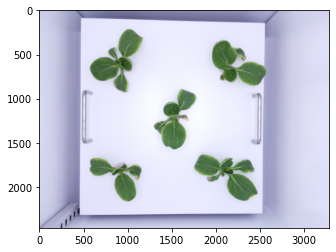

CASE01_02.png
leaf_weight : 59.764


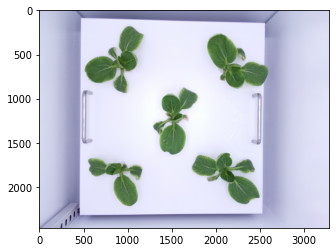

CASE01_03.png
leaf_weight : 72.209


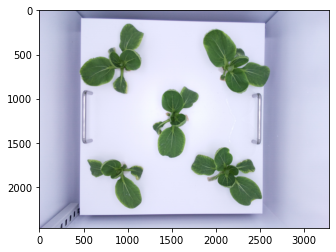

CASE01_04.png
leaf_weight : 85.737


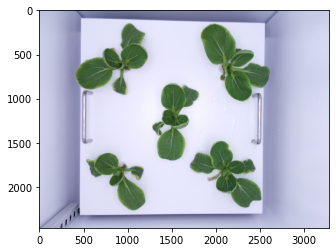

CASE01_05.png
leaf_weight : 102.537


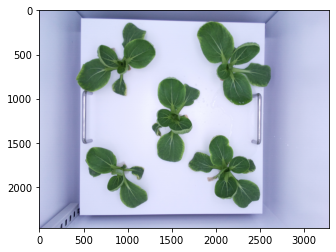

CASE01_06.png
leaf_weight : 123.359


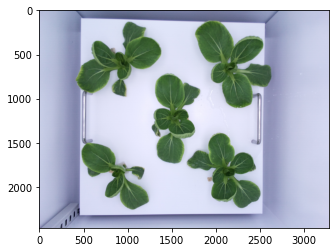

CASE01_07.png
leaf_weight : 156.149


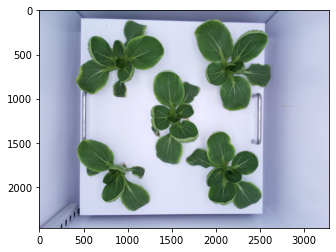

CASE01_08.png
leaf_weight : 174.931


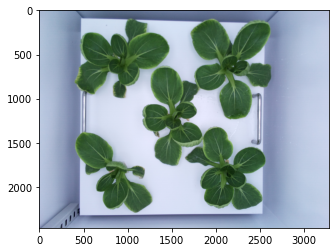

CASE01_09.png
leaf_weight : 187.523


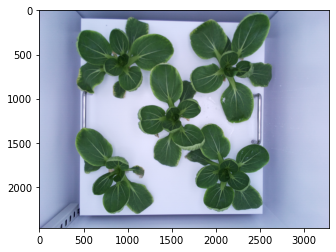

In [6]:
images = glob(train_cases[0]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[0]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [7]:
# # 분석에 사용할 feature 선택
# csv_features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
#        '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
#        '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량']

# csv_files = sorted(glob('/content/drive/MyDrive/KIST/open/train/*/meta/*'))

# temp_csv = pd.read_csv(csv_files[0])[csv_features]
# max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# # feature 별 최대값, 최솟값 계산
# for csv in tqdm(csv_files[1:]):
#     temp_csv = pd.read_csv(csv)[csv_features]
#     temp_csv = temp_csv.fillna(0)
#     if len(temp_csv) == 0:
#         continue
#     temp_csv = temp_csv.astype(float)
#     temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
#     max_arr = np.max([max_arr,temp_max], axis=0)
#     min_arr = np.min([min_arr,temp_min], axis=0)

# # feature 별 최대값, 최솟값 dictionary 생성
# csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
# csv_feature_dict

In [8]:
csv_feature_dict = {'CO2관측치': [0.0, 1757.0],
 'EC관측치': [-0.00080744, 43.59114074707031],
 '난방부하': [0.0, 68.50000381469727],
 '난방온도': [0.0, 26.0],
 '내부습도관측치': [0.0, 110.6199913],
 '내부온도관측치': [0.0, 40.59999847412109],
 '냉방부하': [0.0, 403.5995],
 '냉방온도': [0.0, 28.0],
 '레드 LED동작강도': [0.0, 201.0],
 '백색광추정광량': [0.0, 309.41],
 '블루 LED동작강도': [0.0, 201.0],
 '외부습도관측치': [0.0, 201.0],
 '외부온도관측치': [0.0, 89.4000015258789],
 '적색광추정광량': [0.0, 165.48],
 '총추정광량': [0.0, 631.54],
 '최근분무량': [0.0, 642997.3999999999],
 '화이트 LED동작강도': [0.0, 201.0]}

In [9]:
train = pd.DataFrame({'img':[0],'csv':[0],'weight':[0]})
for case in tqdm(train_cases):
  img_train = sorted(glob(case + '/image/*'))
  csv_train = sorted(glob(case + '/meta/*'))
  weights = pd.read_csv(case + '/label.csv')['leaf_weight']
  temp = pd.DataFrame({'img':img_train,'csv':csv_train,'weight':weights})
  train=pd.concat([train,temp], axis=0)
train = train[1:].reset_index(drop=True)
train

100%|██████████| 75/75 [01:01<00:00,  1.22it/s]


,img,csv,weight
0,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,49.193
1,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,59.764
2,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,72.209
3,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,85.737
4,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,102.537
...,...,...,...
1587,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,211.497
1588,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.116
1589,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.293
1590,/content/drive/MyDrive/KIST/open/train/CASE75/...,/content/drive/MyDrive/KIST/open/train/CASE75/...,210.872


In [10]:
img_files = sorted(glob('/content/drive/MyDrive/KIST/open/test/image/*'))
metas = sorted(glob('/content/drive/MyDrive/KIST/open/test/meta/*'))
test = pd.DataFrame({'img':img_files, 'csv':metas})
test

,img,csv
0,/content/drive/MyDrive/KIST/open/test/image/00...,/content/drive/MyDrive/KIST/open/test/meta/001...
1,/content/drive/MyDrive/KIST/open/test/image/00...,/content/drive/MyDrive/KIST/open/test/meta/002...
2,/content/drive/MyDrive/KIST/open/test/image/00...,/content/drive/MyDrive/KIST/open/test/meta/003...
3,/content/drive/MyDrive/KIST/open/test/image/00...,/content/drive/MyDrive/KIST/open/test/meta/004...
4,/content/drive/MyDrive/KIST/open/test/image/00...,/content/drive/MyDrive/KIST/open/test/meta/005...
...,...,...
455,/content/drive/MyDrive/KIST/open/test/image/45...,/content/drive/MyDrive/KIST/open/test/meta/456...
456,/content/drive/MyDrive/KIST/open/test/image/45...,/content/drive/MyDrive/KIST/open/test/meta/457...
457,/content/drive/MyDrive/KIST/open/test/image/45...,/content/drive/MyDrive/KIST/open/test/meta/458...
458,/content/drive/MyDrive/KIST/open/test/image/45...,/content/drive/MyDrive/KIST/open/test/meta/459...


In [11]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train', transforms=None):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.transforms = transforms

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        # file = self.files[i]
        # file_name = file.split('/')[-1]
        image_path = self.files['img'][i]
        csv_path = self.files['csv'][i]
        
        # csv
        if self.csv_feature_check[i] == 0:
            df = pd.read_csv(csv_path)
            df = df[self.csv_feature_dict.keys()]
            df = df.fillna(0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        img = cv2.imread(image_path)
        if self.transforms is not None:
          img = self.transforms(image=img)['image']
        
        if self.mode == 'train':
            weight = self.files['weight'][i]
            # json_path = f'{file}/{file_name}.json'
            # with open(json_path, 'r') as f:
            #     json_file = json.load(f)
            
            # crop = json_file['annotations']['crop']
            # disease = json_file['annotations']['disease']
            # risk = json_file['annotations']['risk']
            # label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                # 타겟 타입 float로 바꾸기
                'target' : torch.tensor(weight, dtype=torch.float32)
            }
        else:
            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [35]:
device = torch.device("cuda:0")
batch_size = 4
# class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 600
height = 600
width = 600
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 20
k_folds = 5
vision_pretrain = True
save_path = '/content/drive/MyDrive/220515/'

In [36]:
num_features

17

In [37]:
# train = sorted(glob('/content/train/*'))
# test = sorted(glob('/content/test/*'))

# labelsss = pd.read_csv('/content/drive/MyDrive/LG/train.csv')['label']

In [38]:
# train_transforms = A.Compose([
#         A.Resize(height=height, width=width, interpolation=cv2.INTER_AREA),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.Rotate(25, interpolation=cv2.INTER_AREA),
#         A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         ToTensorV2(),
# ])

train_transforms = A.Compose([
        A.Resize(height=height, width=width, interpolation=cv2.INTER_AREA),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
])

In [39]:
test_transforms = A.Compose([
        A.Resize(height=height, width=width, interpolation=cv2.INTER_AREA),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [40]:
train_dataset = CustomDataset(train, transforms = train_transforms)
test_dataset = CustomDataset(test, mode = 'test', transforms = test_transforms)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

In [41]:
next(iter(train_dataset))

{'csv_feature': tensor([[0.3244, 0.3256, 0.3267,  ..., 0.3267, 0.3267, 0.3290],
         [0.3785, 0.3808, 0.3785,  ..., 0.3579, 0.3579, 0.3579],
         [0.1533, 0.1533, 0.1533,  ..., 0.1022, 0.1022, 0.1095],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.0000, 1.0000]]),
 'img': tensor([[[1.7865, 1.8037, 1.7865,  ..., 1.9235, 1.9235, 1.9235],
          [1.8037, 1.8037, 1.8208,  ..., 1.9407, 1.9407, 1.9578],
          [1.7865, 1.8037, 1.8037,  ..., 1.9407, 1.9578, 1.9407],
          ...,
          [1.3584, 1.2385, 1.1700,  ..., 2.0092, 2.0092, 1.9920],
          [1.2728, 1.1529, 1.0502,  ..., 2.0263, 2.0263, 2.0092],
          [1.1872, 1.0502, 0.9646,  ..., 2.0092, 2.0092, 2.0092]],
 
         [[1.4832, 1.4832, 1.4657,  ..., 1.6057, 1.5882, 1.5707],
          [1.4832, 1.4832, 1.5182,  ..., 1.6408, 1.6408, 1.6232],
          [1.4657, 1.4832,

In [42]:
class CNN_Encoder(nn.Module):
    def __init__(self, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.convnext_large(pretrained=True)
        # self.model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

In [43]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 100)
        self.final_layer = nn.Linear(100 + 1000, 1) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

In [44]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [45]:
model = models.convnext_large(pretrained=True)
# model = model.to(device)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

## 학습

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

criterion = nn.L1Loss()

In [47]:
from sklearn.metrics import mean_absolute_error

In [48]:
def accuracy_function(real, pred):    
    real = real.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    score = mean_absolute_error(real, pred)
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['target'].to(device)
    new_shape = (len(label), 1)
    label = label.view(new_shape)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [49]:
# loss_plot, val_loss_plot = [], []
# metric_plot, val_metric_plot = [], []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
  my_file = Path(save_path+'best_model'+str(fold)+'.pt')

  gc.collect()
  loss_plot, val_loss_plot = [], []
  metric_plot, val_metric_plot = [], []
  
  # Print
  print('')
  print(f'FOLD {fold}')
  print('--------------------------------')

  if my_file.is_file():
    continue
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  train_dataloader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=batch_size, sampler=train_subsampler, num_workers=2)
  val_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size, sampler=test_subsampler, num_workers=2)
  
  model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, rate=dropout_rate)
  # model.load_state_dict(torch.load(save_path+'pretrained_model.pt', map_location=device), strict=False)
  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                          lr_lambda=lambda epoch: 0.95 ** epoch,
                                          last_epoch=-1,
                                          verbose=False)

  criterion = nn.L1Loss()
  
  for epoch in range(epochs):
      gc.collect()
      total_loss, total_val_loss = 0, 0
      total_acc, total_val_acc = 0, 0
      
      tqdm_dataset = tqdm(enumerate(train_dataloader))
      training = True
      for batch, batch_item in tqdm_dataset:
          batch_loss, batch_acc = train_step(batch_item, training)
          total_loss += batch_loss
          total_acc += batch_acc
          
          tqdm_dataset.set_postfix({
              'Epoch': epoch + 1,
              'Loss': '{:06f}'.format(batch_loss.item()),
              'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
              'Mean MAE' : '{:06f}'.format(total_acc/(batch+1))
          })
      loss_plot.append(total_loss/(batch+1))
      metric_plot.append(total_acc/(batch+1))
      
      tqdm_dataset = tqdm(enumerate(val_dataloader))
      training = False
      for batch, batch_item in tqdm_dataset:
          batch_loss, batch_acc = train_step(batch_item, training)
          total_val_loss += batch_loss
          total_val_acc += batch_acc
          
          tqdm_dataset.set_postfix({
              'Epoch': epoch + 1,
              'Val Loss': '{:06f}'.format(batch_loss.item()),
              'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
              'Mean Val MAE' : '{:06f}'.format(total_val_acc/(batch+1))
          })
      val_loss_plot.append(total_val_loss/(batch+1))
      val_metric_plot.append(total_val_acc/(batch+1))
      scheduler.step()

      if np.min(val_metric_plot) == val_metric_plot[-1]:
          torch.save(model.state_dict(), save_path+'best_model'+str(fold)+'.pt')
          print('best')

--------------------------------

FOLD 0
--------------------------------

FOLD 1
--------------------------------

FOLD 2
--------------------------------

FOLD 3
--------------------------------


319it [05:50,  1.10s/it, Epoch=1, Loss=63.948502, Mean Loss=38.716225, Mean MAE=38.716231]
80it [01:04,  1.24it/s, Epoch=1, Val Loss=8.760937, Mean Val Loss=17.628782, Mean Val MAE=17.628784]


best


319it [05:50,  1.10s/it, Epoch=2, Loss=38.498489, Mean Loss=20.356457, Mean MAE=20.356452]
80it [01:03,  1.26it/s, Epoch=2, Val Loss=4.617124, Mean Val Loss=8.268630, Mean Val MAE=8.268629]


best


319it [05:50,  1.10s/it, Epoch=3, Loss=2.301001, Mean Loss=16.408028, Mean MAE=16.408034]
80it [01:03,  1.26it/s, Epoch=3, Val Loss=13.548594, Mean Val Loss=8.641410, Mean Val MAE=8.641410]
319it [05:50,  1.10s/it, Epoch=4, Loss=5.268250, Mean Loss=15.649739, Mean MAE=15.649745]
80it [01:03,  1.25it/s, Epoch=4, Val Loss=2.693009, Mean Val Loss=9.150417, Mean Val MAE=9.150416]
319it [05:49,  1.10s/it, Epoch=5, Loss=2.231531, Mean Loss=14.860385, Mean MAE=14.860381]
80it [01:03,  1.27it/s, Epoch=5, Val Loss=2.852168, Mean Val Loss=10.616925, Mean Val MAE=10.616928]
319it [05:50,  1.10s/it, Epoch=6, Loss=5.363111, Mean Loss=12.829026, Mean MAE=12.829028]
80it [01:03,  1.25it/s, Epoch=6, Val Loss=4.577040, Mean Val Loss=5.892997, Mean Val MAE=5.892997]


best


319it [05:50,  1.10s/it, Epoch=7, Loss=11.856998, Mean Loss=13.016678, Mean MAE=13.016676]
80it [01:03,  1.25it/s, Epoch=7, Val Loss=1.652380, Mean Val Loss=7.674053, Mean Val MAE=7.674053]
319it [05:49,  1.10s/it, Epoch=8, Loss=74.857269, Mean Loss=11.039511, Mean MAE=11.039510]
80it [01:04,  1.25it/s, Epoch=8, Val Loss=5.047485, Mean Val Loss=4.527145, Mean Val MAE=4.527145]


best


319it [05:50,  1.10s/it, Epoch=9, Loss=3.943716, Mean Loss=14.984340, Mean MAE=14.984338]
80it [01:03,  1.26it/s, Epoch=9, Val Loss=2.166672, Mean Val Loss=6.147215, Mean Val MAE=6.147215]
319it [05:49,  1.10s/it, Epoch=10, Loss=9.100061, Mean Loss=11.528471, Mean MAE=11.528472]
80it [01:04,  1.24it/s, Epoch=10, Val Loss=2.571134, Mean Val Loss=11.666805, Mean Val MAE=11.666807]
319it [05:49,  1.10s/it, Epoch=11, Loss=3.477812, Mean Loss=11.952901, Mean MAE=11.952907]
80it [01:04,  1.25it/s, Epoch=11, Val Loss=1.320634, Mean Val Loss=8.481557, Mean Val MAE=8.481554]
319it [05:49,  1.10s/it, Epoch=12, Loss=2.503374, Mean Loss=12.781687, Mean MAE=12.781686]
80it [01:03,  1.25it/s, Epoch=12, Val Loss=5.444847, Mean Val Loss=10.712296, Mean Val MAE=10.712295]
319it [05:50,  1.10s/it, Epoch=13, Loss=3.298126, Mean Loss=11.509519, Mean MAE=11.509517]
80it [01:04,  1.24it/s, Epoch=13, Val Loss=0.308277, Mean Val Loss=10.143344, Mean Val MAE=10.143343]
319it [05:50,  1.10s/it, Epoch=14, Loss=1


FOLD 4
--------------------------------


319it [05:50,  1.10s/it, Epoch=1, Loss=52.034187, Mean Loss=35.944023, Mean MAE=35.944039]
80it [01:04,  1.23it/s, Epoch=1, Val Loss=8.773063, Mean Val Loss=20.173326, Mean Val MAE=20.173326]


best


319it [05:50,  1.10s/it, Epoch=2, Loss=12.038246, Mean Loss=19.045507, Mean MAE=19.045509]
80it [01:04,  1.24it/s, Epoch=2, Val Loss=34.075043, Mean Val Loss=13.020612, Mean Val MAE=13.020614]


best


319it [05:50,  1.10s/it, Epoch=3, Loss=3.550930, Mean Loss=16.123158, Mean MAE=16.123171]
80it [01:04,  1.23it/s, Epoch=3, Val Loss=41.585644, Mean Val Loss=18.027615, Mean Val MAE=18.027611]
319it [05:50,  1.10s/it, Epoch=4, Loss=3.039599, Mean Loss=14.464384, Mean MAE=14.464386]
80it [01:04,  1.24it/s, Epoch=4, Val Loss=3.720467, Mean Val Loss=10.057563, Mean Val MAE=10.057563]


best


319it [05:50,  1.10s/it, Epoch=5, Loss=1.214469, Mean Loss=14.062797, Mean MAE=14.062800]
80it [01:04,  1.23it/s, Epoch=5, Val Loss=33.777786, Mean Val Loss=10.582323, Mean Val MAE=10.582322]
319it [05:50,  1.10s/it, Epoch=6, Loss=2.661304, Mean Loss=14.274677, Mean MAE=14.274679]
80it [01:04,  1.23it/s, Epoch=6, Val Loss=3.580624, Mean Val Loss=8.372157, Mean Val MAE=8.372157]


best


319it [05:50,  1.10s/it, Epoch=7, Loss=1.117234, Mean Loss=13.603198, Mean MAE=13.603197]
80it [01:04,  1.24it/s, Epoch=7, Val Loss=15.131786, Mean Val Loss=9.577168, Mean Val MAE=9.577166]
319it [05:50,  1.10s/it, Epoch=8, Loss=2.886377, Mean Loss=13.559255, Mean MAE=13.559254]
80it [01:04,  1.24it/s, Epoch=8, Val Loss=1.527134, Mean Val Loss=8.602293, Mean Val MAE=8.602295]
319it [05:51,  1.10s/it, Epoch=9, Loss=0.456657, Mean Loss=13.891211, Mean MAE=13.891211]
80it [01:08,  1.17it/s, Epoch=9, Val Loss=1.091528, Mean Val Loss=7.801735, Mean Val MAE=7.801735]


best


319it [05:57,  1.12s/it, Epoch=10, Loss=4.997000, Mean Loss=12.846248, Mean MAE=12.846247]
80it [01:15,  1.05it/s, Epoch=10, Val Loss=5.685226, Mean Val Loss=9.009682, Mean Val MAE=9.009683]
319it [06:06,  1.15s/it, Epoch=11, Loss=2.096610, Mean Loss=11.983840, Mean MAE=11.983845]
80it [01:15,  1.06it/s, Epoch=11, Val Loss=14.110455, Mean Val Loss=11.541464, Mean Val MAE=11.541463]
319it [06:06,  1.15s/it, Epoch=12, Loss=10.009995, Mean Loss=11.435399, Mean MAE=11.435399]
80it [01:16,  1.05it/s, Epoch=12, Val Loss=1.920482, Mean Val Loss=9.484542, Mean Val MAE=9.484542]
319it [05:52,  1.10s/it, Epoch=13, Loss=9.253966, Mean Loss=11.147190, Mean MAE=11.147185]
80it [01:05,  1.22it/s, Epoch=13, Val Loss=7.106056, Mean Val Loss=14.150699, Mean Val MAE=14.150701]
319it [05:51,  1.10s/it, Epoch=14, Loss=1.865782, Mean Loss=13.181870, Mean MAE=13.181871]
80it [01:05,  1.23it/s, Epoch=14, Val Loss=8.754574, Mean Val Loss=7.391875, Mean Val MAE=7.391876]


best


319it [05:51,  1.10s/it, Epoch=15, Loss=1.857758, Mean Loss=12.961464, Mean MAE=12.961461]
80it [01:05,  1.23it/s, Epoch=15, Val Loss=9.636016, Mean Val Loss=9.341332, Mean Val MAE=9.341332]
319it [05:51,  1.10s/it, Epoch=16, Loss=6.254251, Mean Loss=11.988914, Mean MAE=11.988913]
80it [01:04,  1.25it/s, Epoch=16, Val Loss=6.415840, Mean Val Loss=8.627604, Mean Val MAE=8.627604]
319it [05:51,  1.10s/it, Epoch=17, Loss=5.657070, Mean Loss=10.644811, Mean MAE=10.644811]
80it [01:04,  1.23it/s, Epoch=17, Val Loss=11.202415, Mean Val Loss=9.456161, Mean Val MAE=9.456160]
319it [05:50,  1.10s/it, Epoch=18, Loss=2.756374, Mean Loss=10.764740, Mean MAE=10.764744]
80it [01:04,  1.23it/s, Epoch=18, Val Loss=31.316689, Mean Val Loss=10.062788, Mean Val MAE=10.062787]
319it [05:50,  1.10s/it, Epoch=19, Loss=164.919037, Mean Loss=12.258477, Mean MAE=12.258478]
80it [01:04,  1.24it/s, Epoch=19, Val Loss=18.682049, Mean Val Loss=7.697013, Mean Val MAE=7.697014]
319it [05:50,  1.10s/it, Epoch=20, Los

In [50]:
batch_size = 4

In [51]:
def predict(dataset, model0, model1, model2, model3, model4):
    model0.eval()
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
      img = batch_item['img'].to(device)
      seq = batch_item['csv_feature'].to(device)
      with torch.no_grad():
          output = 0.2*model0(img, seq) + 0.2*model1(img, seq) + 0.2*model2(img, seq) + 0.2*model3(img, seq) + 0.2*model4(img, seq)
          # output = 0.5*model0(img, seq) + 0.5*model1(img, seq)
      # output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
      results.extend(output.cpu().numpy())
    return results

model0 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, rate=dropout_rate)
model0.load_state_dict(torch.load(save_path+'best_model'+str(0)+'.pt', map_location=device))
model0.to(device)

model1 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, rate=dropout_rate)
model1.load_state_dict(torch.load(save_path+'best_model'+str(1)+'.pt', map_location=device))
model1.to(device)

model2 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, rate=dropout_rate)
model2.load_state_dict(torch.load(save_path+'best_model'+str(2)+'.pt', map_location=device))
model2.to(device)

model3 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, rate=dropout_rate)
model3.load_state_dict(torch.load(save_path+'best_model'+str(3)+'.pt', map_location=device))
model3.to(device)

model4 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, rate=dropout_rate)
model4.load_state_dict(torch.load(save_path+'best_model'+str(4)+'.pt', map_location=device))
model4.to(device)

preds = predict(test_dataloader, model0, model1)

TypeError: ignored

In [ ]:
len(preds)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/KIST/open/sample_submission.csv')

In [ ]:
submission['leaf_weight'] = np.array(preds).reshape(1,-1)[0]
submission

In [ ]:
submission[submission['leaf_weight']<0]

In [ ]:
submission.loc[submission['leaf_weight']<0, 'leaf_weight'] = 0

In [ ]:
images = glob('/content/drive/MyDrive/KIST/open/test/image/*')
images.sort()
for i in range(10):
  image = cv2.imread(images[i])
  print(images[i][-13:])
  print('leaf_weight : ' + str(submission['leaf_weight'].loc[i]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
submission.to_csv('/content/drive/MyDrive/KIST/submission.csv', index=False)